In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from copy import deepcopy
from importlib import import_module

import numpy as np
import torch
from omegaconf import OmegaConf
from torch import nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.integrate as integrate

plt.rc("font", **{"size": 20})
plt.rc("lines", linewidth=4.0)
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig_size = 6

In [2]:
cfg = OmegaConf.create(
    {
        "num_pathways": 7,  # this is M
        # for the ith layer, hidden_dims[i] is the input dim and
        # hidden_dims[i+1] is the output dim
        "hidden_dims": [64, 64, 64, 64],
        "input_dim": 4,
        "output_dim": 7,
        "case": "1",
        "init_scale": .2,
        "should_init_decoupled": False,
        "should_use_bias": False,
        "num_epochs": 500,
        "loss": {
            "cls": "torch.nn.MSELoss",
            "reduction": "none",
        },
        "optimizer": {
            "cls": "torch.optim.SGD",
            "lr": .02,  # .005,#.01,
            "momentum": 0,
            "dampening": 0,
            "weight_decay": 0,
            "nesterov": False,
        },
        "gate": {
            # other supported modes are: mod, k_plus_mod, k_plus_minus_mod
            # where k is an integer
            "mode": "4_plus_minus_mod",
            "num_classes": 4
        },
        "num_trained_pathways": 4
    }
)
# cfg is a dictionary with "." access eg cfg["abc"] == cfg.abc

device = torch.device("cpu")

In [3]:
######
X = torch.eye(n=cfg.input_dim).to(device)
Y = (
    torch.cat(
        [
            6.*torch.ones((1, cfg.input_dim)),
            torch.tensor([4, 4, 0, 0]).unsqueeze(0),
            torch.tensor([0, 0, 4,4]).unsqueeze(0),
            3*torch.eye(n=cfg.input_dim),
        ]
    )
    .to(device)
    .t()
)

print(f"X: {X}")
print(f"Y: {Y}")
print("Created Tensors")

X: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Y: tensor([[6., 4., 0., 3., 0., 0., 0.],
        [6., 4., 0., 0., 3., 0., 0.],
        [6., 0., 4., 0., 0., 3., 0.],
        [6., 0., 4., 0., 0., 0., 3.]])
Created Tensors


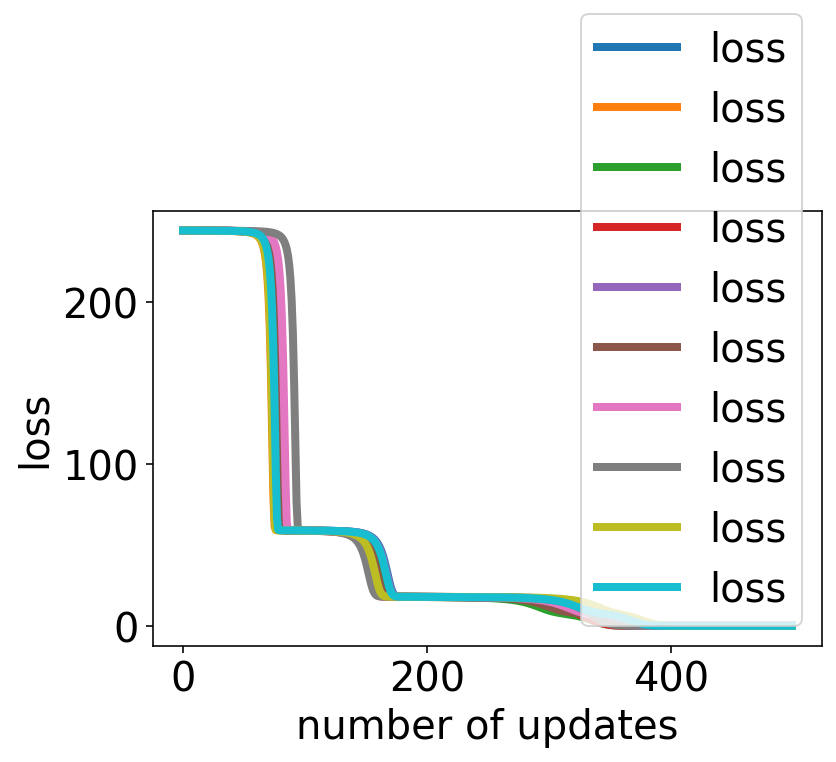

In [4]:
class GatedDLN(nn.Module):
    def __init__(
            self,
            num_tasks,
            input_dim,
            hidden_dims,
            output_dim,
            case,
            should_use_bias):
        self.tasks = OmegaConf.create({"shape": [num_tasks, num_tasks]})
        super().__init__()
        self.input = nn.ModuleList(
            [
                nn.Linear(input_dim, hidden_dims[0], bias=should_use_bias)
                for _ in range(num_tasks)
            ]
        )
        self.hidden = nn.Linear(
            hidden_dims[0],
            hidden_dims[1],
            bias=should_use_bias)
        self.out = nn.ModuleList(
            [
                nn.Linear(hidden_dims[-1], output_dim, bias=should_use_bias)
                for _ in range(num_tasks)
            ]
        )
        self.gate = self.make_gate()
        self.loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    def make_gate(self):
        # feel free to define a gate yourself
        mode = cfg.gate.mode
        if mode == "fully_connected":
            gate = torch.ones(
                *self.tasks.shape,
                device="cpu",
                dtype=torch.float32)
            return gate.unsqueeze(2)

        input_output_map = self._get_input_output_map(mode=mode)
        gate = torch.zeros(
            *self.tasks.shape,
            device="cpu",
            dtype=torch.float32)
        for current_input, current_output in input_output_map:
            gate[current_input][current_output] = 1.0
        if mode.endswith("permute"):
            gate = gate[:, torch.randperm(gate.shape[1])]
        # print(gate)
        #print(gate.shape, gate.sum().item())
        return gate.unsqueeze(2)

    def _get_input_output_map(self, mode: str):
        input_output_map = []
        if "_plus_mod" in mode:
            num_cols = int(mode.split("_plus_mod")[0])
            num_rows = self.tasks.shape[0]
            for i in range(num_rows):
                for j in range(num_cols):
                    input_output_map.append((i, (i + j) % num_rows))
        elif "_plus_minus_mod" in mode:
            num_cols = int(mode.split("_plus_minus_mod")[0])
            num_rows = self.tasks.shape[0]
            for i in range(num_rows):
                for j in range(-1 * ((num_cols - 1) // 2),
                               (num_cols // 2) + 1):
                    input_output_map.append((i, (i + j + num_rows) % num_rows))
        elif mode == "mod":
            for i in range(min(cfg.gate.num_classes, self.tasks.shape[0])):
                input_output_map.append((i, i))
        else:
            raise NotImplementedError(f"mode = {mode} is not supported.")
        #print(f"input_output_map: {input_output_map}")
        return input_output_map

    def to(self, device, *args, **kwargs):
        self.gate = self.gate.to(device)
        return super().to(device, *args, **kwargs)

    def forward(self, x, y):
        features = [
            encoder(x) for encoder in model.input
        ]
        hidden = [model.hidden(f) for f in features]
        #outputs = [[d(h) for d in model.out] for h in hidden]

        M = cfg.num_pathways
        loss_tensor = torch.zeros(M, M)
        for i, a in enumerate(hidden):
            for j, b in enumerate(model.out):
                if model.gate.squeeze()[i, j] == 1:
                    loss_tensor[i, j] = model.loss_fn(b(a), y).mean()

        loss = loss_tensor.sum()
        return loss


def run_one_input_per_module(x_list, module_list):
    return torch.cat([module(x).unsqueeze(0)
                      for x, module in zip(x_list, module_list)], dim=0)


def run_one_domain_per_module(x_list, module_list):
    return [module(x_list) for module in module_list]


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight, gain=cfg.init_scale)
        


def make_cls(cfg, kwargs=None):
    module, cls = cfg.pop("cls").rsplit(".", 1)
    if kwargs is None:
        kwargs = {}
    return getattr(import_module(module), cls)(**cfg, **kwargs)


device = torch.device("cpu")

Nreps = 10

losses = []
input_svs = []
hidden_svs = []
out_svs = []

for rep in range(Nreps):
    model = GatedDLN(
        num_tasks=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)


    if not cfg.should_init_decoupled:
        model.apply(init_weights)

    else:
    # Fully balanced, decoupled init

        with torch.no_grad():

            u,s,v = np.linalg.svd(Y.T)
            Ninp = cfg.input_dim
            Nh = cfg.hidden_dims[0]
            Nout = cfg.output_dim
            r2,_,r1 = np.linalg.svd(model.hidden.weight)
            for m in model.input:
                m.weight = torch.nn.Parameter(torch.tensor((r1.T)[:,0:Ninp] @ ( cfg.init_scale*np.eye(Ninp) ) @ v, dtype=torch.float))

            #r3,_,r4 = np.linalg.svd(np.random.normal(0,1,model.hidden.weight.shape))
            model.hidden.weight = torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))#torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))

            for m in model.out:
                m.weight = torch.nn.Parameter(torch.tensor(u @ ( cfg.init_scale*np.eye(Nout) ) @ (r2.T)[0:Nout,:], dtype=torch.float))


    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
                "params": model.parameters()})

    loss_list = []

    input_sv_list = []
    hidden_sv_list = []
    out_sv_list = []


    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        loss = model(X, Y)
        loss_list.append(loss.detach().cpu())

        if epoch%2==0:
            ui,si,vi = np.linalg.svd(model.input[0].weight.detach().numpy())
            input_sv_list.append(si)

            uh,sh,vh = np.linalg.svd(model.hidden.weight.detach().numpy())
            hidden_sv_list.append(sh[0:10])

            uo,so,vo = np.linalg.svd(model.out[0].weight.detach().numpy())
            out_sv_list.append(so[0:7])


        loss.backward()
        optimizer.step()


    plt.plot(loss_list, label="loss")
    plt.xlabel("number of updates")
    plt.ylabel("loss")
    plt.legend()

    losses.append(np.vstack(loss_list))
    input_svs.append(np.vstack(input_sv_list))
    hidden_svs.append(np.vstack(hidden_sv_list))
    out_svs.append(np.vstack(out_sv_list))


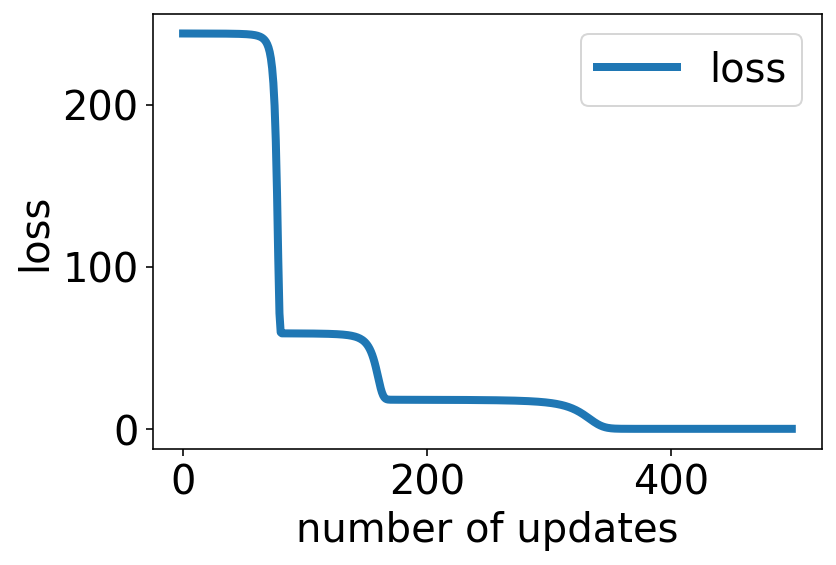

In [5]:
cfg.should_init_decoupled=True
cfg.init_scale = .2/2.5

Nreps_decoup = 1

losses_decoup = []
input_svs_decoup = []
hidden_svs_decoup = []
out_svs_decoup = []

for rep in range(Nreps_decoup):
    model = GatedDLN(
        num_tasks=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)


    if not cfg.should_init_decoupled:
        model.apply(init_weights)

    else:
    # Fully balanced, decoupled init

        with torch.no_grad():

            u,s,v = np.linalg.svd(Y.T)
            Ninp = cfg.input_dim
            Nh = cfg.hidden_dims[0]
            Nout = cfg.output_dim
            r2,_,r1 = np.linalg.svd(model.hidden.weight)
            for m in model.input:
                m.weight = torch.nn.Parameter(torch.tensor((r1.T)[:,0:Ninp] @ ( cfg.init_scale*np.eye(Ninp) ) @ v, dtype=torch.float))

            #r3,_,r4 = np.linalg.svd(np.random.normal(0,1,model.hidden.weight.shape))
            model.hidden.weight = torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))#torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))

            for m in model.out:
                m.weight = torch.nn.Parameter(torch.tensor(u @ ( cfg.init_scale*np.eye(Nout) ) @ (r2.T)[0:Nout,:], dtype=torch.float))


    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
                "params": model.parameters()})

    loss_list = []

    input_sv_list = []
    hidden_sv_list = []
    out_sv_list = []


    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        loss = model(X, Y)
        loss_list.append(loss.detach().cpu())

        if epoch%2==0:
            ui,si,vi = np.linalg.svd(model.input[0].weight.detach().numpy())
            input_sv_list.append(si)

            uh,sh,vh = np.linalg.svd(model.hidden.weight.detach().numpy())
            hidden_sv_list.append(sh[0:10])

            uo,so,vo = np.linalg.svd(model.out[0].weight.detach().numpy())
            out_sv_list.append(so[0:7])


        loss.backward()
        optimizer.step()


    plt.plot(loss_list, label="loss")
    plt.xlabel("number of updates")
    plt.ylabel("loss")
    plt.legend()

    losses_decoup.append(np.vstack(loss_list))
    input_svs_decoup.append(np.vstack(input_sv_list))
    hidden_svs_decoup.append(np.vstack(hidden_sv_list))
    out_svs_decoup.append(np.vstack(out_sv_list))

In [6]:
cfg.num_trained_pathways

4

In [7]:
# Theory ODE

u,s,v = np.linalg.svd(np.dot(Y.T,X))
# Code currently assumes input corrs are white

K = cfg.num_trained_pathways
M =  cfg.num_pathways

b0 = cfg.init_scale
dt = cfg.optimizer.lr*3.5/10




Nsv = s.shape[0]

num_epochs = cfg.num_epochs*10
b1 = b0*np.ones((num_epochs,Nsv))
b2 = b0*np.ones((num_epochs,Nsv))
b3 = b0*np.ones((num_epochs,Nsv))

c0 = M*b0**2-b0**2

theta0 = 2*np.arcsinh(b0/np.sqrt(c0))
theta = theta0*np.ones((num_epochs,Nsv))
theta2 = theta0*np.ones((num_epochs,Nsv))

b1t = np.ones((num_epochs,Nsv))
b2t = np.ones((num_epochs,Nsv))

b2s = b0*np.ones((num_epochs,Nsv))

for epoch in range(num_epochs-1):
    
    shat = b3[epoch,:]*b2[epoch,:]*b1[epoch,:]
    b1[epoch+1,:] = b1[epoch,:] + K/M**2*b3[epoch,:]*b2[epoch,:]*(s - shat)*dt
    b2[epoch+1,:] = b2[epoch,:] + K/M*b3[epoch,:]*b1[epoch,:]*(s - shat)*dt
    b3[epoch+1,:] = b3[epoch,:] + K/M**2*b2[epoch,:]*b1[epoch,:]*(s - shat)*dt
    theta2[epoch+1,:] = 2*np.arcsinh(b2[epoch+1,:]/np.sqrt(c0))
    
    theta[epoch+1,:] = theta[epoch,:] + 2*np.sqrt(c0)* K/M**2*np.cosh(theta[epoch,:]/2)*(s - c0**(3/2)/M*np.sinh(theta[epoch,:]/2)*(np.sinh(theta[epoch,:]/2)**2 - 1))*dt #2*K/M**2*np.sqrt(c0)*(np.sinh(theta[epoch,:]/2)**2 - 1)/np.cosh(theta[epoch,:]/2)*(s - c0**(3/2)/M*np.sinh(theta[epoch,:]/2)*(np.sinh(theta[epoch,:]/2)**2 -1))*dt
   
    b2t[epoch+1,:] = np.sqrt(c0)*np.sinh(theta[epoch+1,:]/2)
    b1t[epoch+1,:] = np.sqrt(b2t[epoch+1,:]**2/M+c0/M)
    
    b2s[epoch+1,:] = b2s[epoch,:] + K/M**2*(b2s[epoch,:]**2 + c0)*(s - 1/M*b2s[epoch,:]*(b2s[epoch,:]**2+c0))*dt

In [8]:
integrate.quad(lambda x: M**2/K/( (x**2 + c0)*(s[0]-1/M*x*(x**2+c0)) ),0,13)[0]

/tmp/ipykernel_1641294/2793287623.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(lambda x: M**2/K/( (x**2 + c0)*(s[0]-1/M*x*(x**2+c0)) ),0,13)[0]


7.281847933756849

/tmp/ipykernel_1641294/867867868.py:9: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  ts[:,sv] = np.squeeze(np.vstack([integrate.quad(lambda x: M**2/K/( (x**2 + c0)*(s[sv]-1/M*x*(x**2+c0)) ),b0,l)[0]/dt for l in b2i[:,sv]]))
/tmp/ipykernel_1641294/867867868.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  ts2[:,sv] = np.squeeze(np.vstack([integrate.quad(lambda x: M**2/K/( (x**2)*(s[sv]-1/M*x*(x**2)) ),b02,l)[0]/dt for l in b2i2[:,sv]]))


(0.0, 8000.0)

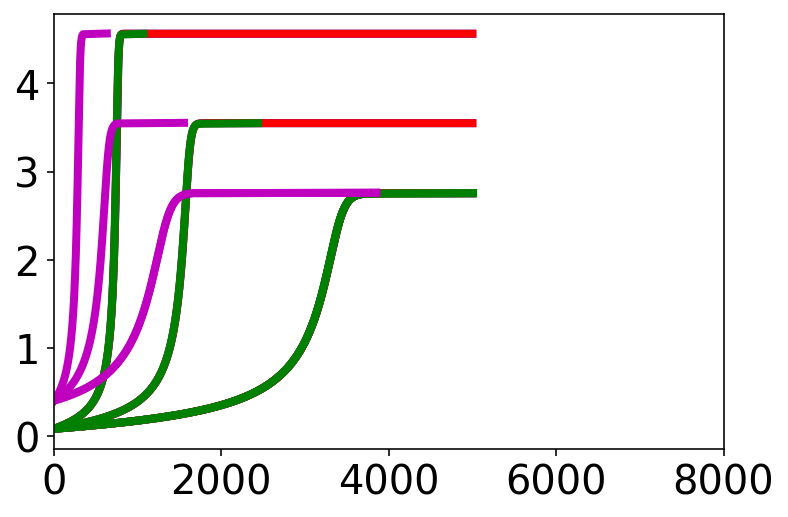

In [9]:


b02 = .4
Npts = 500
b2i = np.zeros((Npts,4))
ts = np.zeros((Npts,4))
ts2 = np.zeros((Npts,4))
b2i2 = np.zeros((Npts,4))
for sv in range(4):
    b2i[:,sv] = np.linspace(b0,b2s[-1,sv],Npts)
    ts[:,sv] = np.squeeze(np.vstack([integrate.quad(lambda x: M**2/K/( (x**2 + c0)*(s[sv]-1/M*x*(x**2+c0)) ),b0,l)[0]/dt for l in b2i[:,sv]]))
    b2i2[:,sv] = np.linspace(b02,(M*s[sv])**(1/3),Npts)
    ts2[:,sv] = np.squeeze(np.vstack([integrate.quad(lambda x: M**2/K/( (x**2)*(s[sv]-1/M*x*(x**2)) ),b02,l)[0]/dt for l in b2i2[:,sv]]))




plt.plot(b2,color='b')
plt.plot(b2s,color='r')
plt.plot(ts,b2i,color='g')
plt.plot(ts2,b2i2,color='m')
plt.xlim((0,8000))

In [10]:
b2i2.shape

(500, 4)

In [11]:
b2i

array([[0.08      , 0.08      , 0.08      , 0.08      ],
       [0.0889849 , 0.08695108, 0.08535929, 0.08535929],
       [0.0979698 , 0.09390217, 0.09071858, 0.09071858],
       ...,
       [4.54549408, 3.53468828, 2.74356612, 2.74356612],
       [4.55447898, 3.54163936, 2.7489254 , 2.7489254 ],
       [4.56346388, 3.54859045, 2.75428469, 2.75428469]])

In [12]:
# Exact solns

c0 = M*b0**2 - b0**2

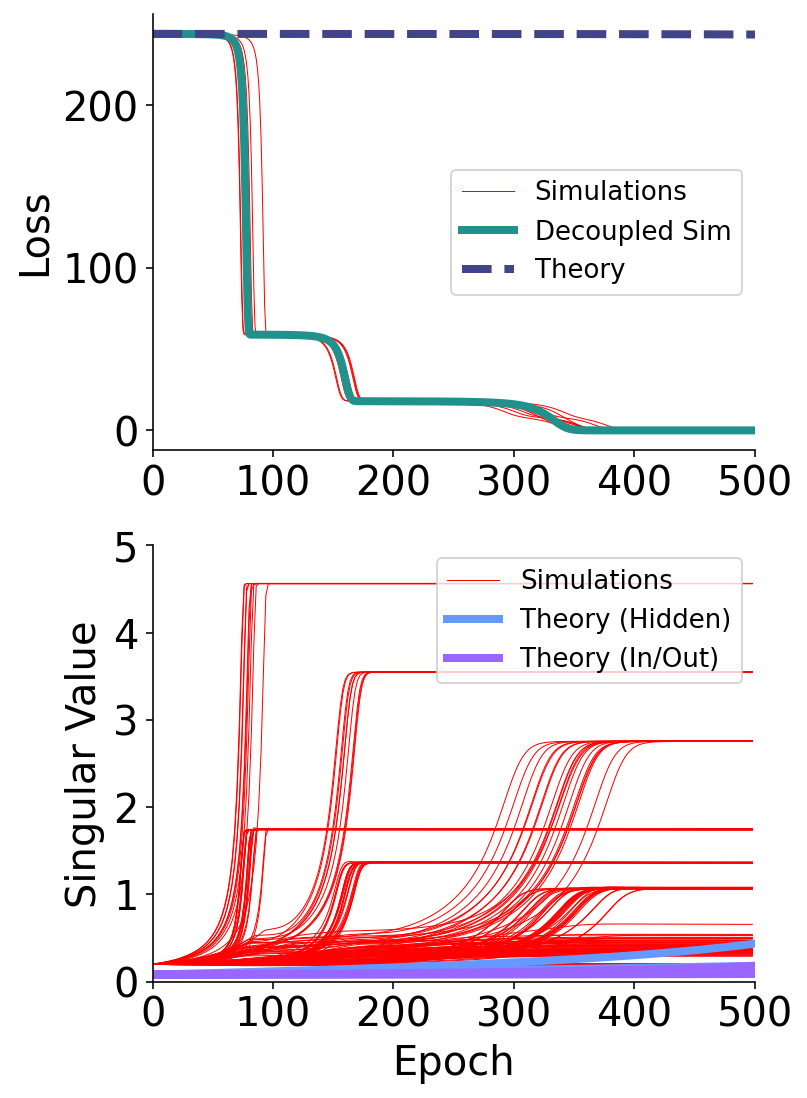

In [13]:
# Save figure
fig = plt.figure(figsize=(6,8))

ax1=plt.subplot(211)
# Simulations from small random weights
for rep in range(Nreps-1):
    plt.plot(losses[rep], color='r', linewidth=.5)
plt.plot(losses[-1], color='r', linewidth=.5, label='Simulations')

# Simulations from balanced decoupled init
plt.plot(losses_decoup[0], color=plt.cm.viridis(.5), linewidth=4, label='Decoupled Sim')

# Reduction
plt.plot(K/4*np.sum((s - b3*b2*b1)**2,axis=1),color=plt.cm.viridis(.2),linestyle='--', label='Theory')

#plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=13)
plt.xlim((0,500))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2=plt.subplot(212)
ep = np.arange(0,cfg.num_epochs,2)

#fig = plt.figure(figsize=(10, 4))

for rep in range(Nreps-1):
    plt.plot(ep,input_svs[rep], color='r', linewidth=.5)
    plt.plot(ep,hidden_svs[rep], color='r', linewidth=.5)
    plt.plot(ep,out_svs[rep], color='r', linewidth=.5)
plt.plot(ep,input_svs[-1][:,0], color='r', linewidth=.5,label='Simulations')
plt.plot(ep,input_svs[-1][:,1:], color='r', linewidth=.5)
plt.plot(ep,hidden_svs[-1], color='r', linewidth=.5)
plt.plot(ep,out_svs[-1], color='r', linewidth=.5)

#plt.plot(b1, color=plt.cm.cool(.2), label='Input')
plt.plot(b2[:,0], color=plt.cm.cool(.4), label='Theory (Hidden)')
plt.plot(b2[:,1:], color=plt.cm.cool(.4))
plt.plot(b3[:,0], color=plt.cm.cool(.6), label='Theory (In/Out)')
plt.plot(b3[:,1:], color=plt.cm.cool(.6))
plt.legend(loc='upper right',fontsize=13)#loc=(1.1,.3))
plt.xlabel("Epoch")
plt.ylabel("Singular Value")
plt.ylim((0,5))
plt.xlim((0,500))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#plt.xlim((100,500))

plt.tight_layout()
#plt.show()

plt.savefig('routing_network_solution.pdf')

Percentage trained: 0.5714285969734192
7


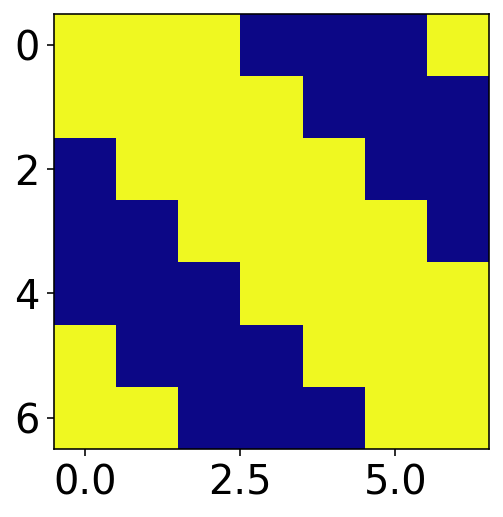

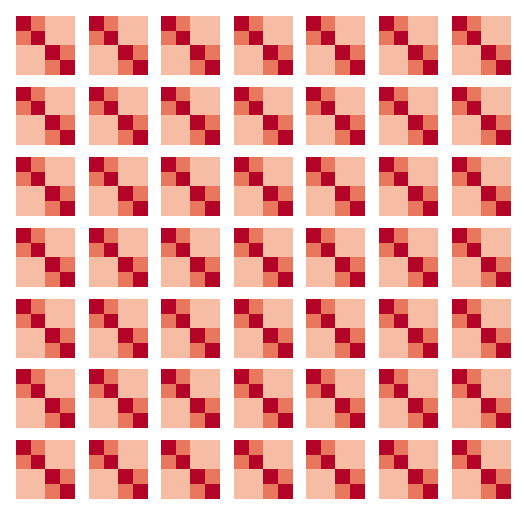

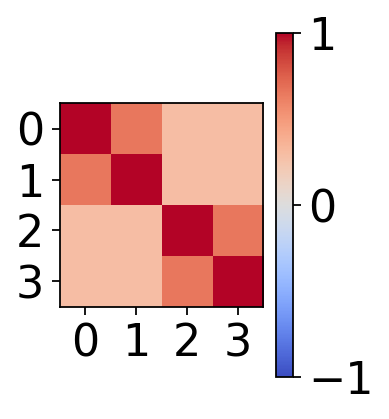

In [14]:
#
plt.imshow(model.gate, cmap=plt.cm.plasma)
plt.savefig('num_trained_panel.pdf')
print(f"Percentage trained: {model.gate.mean()}")
# Compute hidden representation correlations within and across modalities
M = cfg.num_pathways
print(M)
plt.figure(figsize=(4, 4), dpi=80)
for i in range(M):
    i
    outA = model.input[i](X)
    #outA = model.hidden(outA)
    outA = outA.detach().numpy()

    for j in range(M):
        outB = model.input[j](X)
        #outB = model.hidden(outB)
        outB = outB.detach().numpy()

        plt.subplot(M, M, i*M+j+1)
        plt.imshow(np.dot(outA, outB.T), cmap=plt.cm.coolwarm)
        plt.clim(-1,1)
        plt.axis('off')

plt.savefig('routing_rsa_panel.pdf')

plt.figure(figsize=(3, 3), dpi=80)
plt.imshow(np.dot(outA, outB.T), cmap=plt.cm.coolwarm)
plt.clim(-1,1)
label_list = ['1', '2', '3', '4']

plt.gca().set_xticks([0,1,2,3])
# plt.gca().set_xticklabels(x_label_list)
plt.gca().set_yticks([0,1,2,3])
# plt.gca().set_yticklabels(x_label_list)

plt.colorbar()
plt.tight_layout()
plt.savefig('rsa_colorbar.pdf')

7


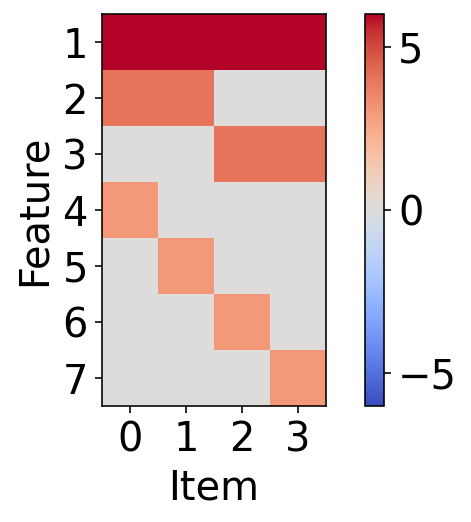

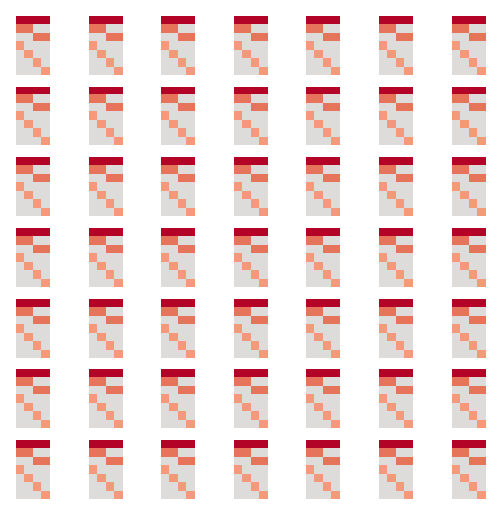

In [15]:
plt.imshow(Y.T, cmap=plt.cm.coolwarm)
plt.clim((-6,6))
plt.colorbar(ticks=[-5, 0, 5])

plt.gca().set_xticks([0,1,2,3])
# plt.gca().set_xticklabels(x_label_list)
plt.gca().set_yticks(np.linspace(0,6,7))
plt.gca().set_yticklabels([r+1 for r in range(7)])
plt.xlabel('Item')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('routing_dataset.pdf')

M = cfg.num_pathways
print(M)
plt.figure(figsize=(4, 4), dpi=80)
for i in range(M):
    outA = model.input[i](X)
    h = model.hidden(outA)

    for j in range(M):
        o = model.out[j](h)

        plt.subplot(M, M, i*M+j+1)
        plt.imshow(o.detach().numpy().T,cmap=plt.cm.coolwarm)
        plt.clim((-6, 6))
        plt.axis('off')

plt.savefig('routing_output.pdf')
#plt.tight_layout()

In [16]:

device = torch.device("cpu")

model = GatedDLN(
    num_tasks=4,
    input_dim=cfg.input_dim,
    hidden_dims=cfg.hidden_dims,
    output_dim=cfg.output_dim,
    case=cfg.case,
    should_use_bias=cfg.should_use_bias,
).to(device)


model.apply(init_weights)
model.gate

tensor([[[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.]]])

In [17]:
def make_cls(cfg, kwargs=None):
    module, cls = cfg.pop("cls").rsplit(".", 1)
    if kwargs is None:
        kwargs = {}
    return getattr(import_module(module), cls)(**cfg, **kwargs)


loss_fn = make_cls(cfg=deepcopy(cfg.loss))

optimizer = make_cls(
    cfg=deepcopy(
        cfg.optimizer), kwargs={
            "params": model.parameters()})

loss_list = []
for epoch in range(cfg.num_epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = torch.sum(torch.cat([loss_fn(o, Y).unsqueeze(0) for o in output]))
    loss_list.append(loss.detach().cpu())
    loss.backward()
    optimizer.step()

plt.plot(loss_list, label="loss")
plt.xlabel("number of updates")
plt.ylabel("loss")
plt.legend()

TypeError: forward() missing 1 required positional argument: 'y'

In [ ]:
plt.imshow(output[0].detach().numpy())

In [ ]:
# Compute hidden representation correlations within and across modalities

outA = model.input[0](X)
outA = model.hidden[0][0](outA)
outA = outA.detach().numpy()

outB = model.input[1](X)
outB = model.hidden[0][1](outB)
outB = outB.detach().numpy()


plt.imshow(np.dot(outA, outA.T))
plt.colorbar()
plt.show()

plt.imshow(np.dot(outA, outB.T))
plt.colorbar()
plt.show()

plt.imshow(np.dot(outB, outB.T))
plt.colorbar()
plt.show()

In [ ]:
Nreps = 10
cfg.num_pathways = 10
res_share = np.zeros((Nreps, cfg.num_epochs))
for r in range(Nreps):
    model = GatedDLN(
        num_pathways=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)

    model.apply(init_weights)

    def make_cls(cfg, kwargs=None):
        module, cls = cfg.pop("cls").rsplit(".", 1)
        if kwargs is None:
            kwargs = {}
        return getattr(import_module(module), cls)(**cfg, **kwargs)

    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
            "params": model.parameters()})

    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.sum(
            torch.cat([loss_fn(o, Y).unsqueeze(0) for o in output]))
        # loss_list.append(loss.detach().cpu()/cfg.num_pathways)
        res_share[r, epoch] = loss.detach().cpu()/cfg.num_pathways
        loss.backward()
        optimizer.step()

    #plt.plot(loss_list, color='r',alpha=.4)
    #plt.xlabel("number of updates")
    # plt.ylabel("loss")
    # plt.legend()

cfg.num_pathways = 1
res_indep = np.zeros((Nreps, cfg.num_epochs))
for r in range(Nreps):
    model = GatedDLN(
        num_pathways=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)

    model.apply(init_weights)

    def make_cls(cfg, kwargs=None):
        module, cls = cfg.pop("cls").rsplit(".", 1)
        if kwargs is None:
            kwargs = {}
        return getattr(import_module(module), cls)(**cfg, **kwargs)

    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
            "params": model.parameters()})

    loss_list = []
    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.sum(
            torch.cat([loss_fn(o, Y).unsqueeze(0) for o in output]))
        # loss_list.append(loss.detach().cpu())
        res_indep[r, epoch] = loss.detach().cpu()
        loss.backward()
        optimizer.step()

    #plt.plot(loss_list, color='b',alpha=.4)
    #plt.xlabel("number of updates")
    # plt.ylabel("loss")
    # plt.legend()

In [ ]:
plt.plot(np.sqrt(np.mean(res_share, axis=0)), label="M=10", color='r')
plt.plot(np.sqrt(res_share.T), color='r', alpha=.2)
plt.plot(np.sqrt(np.mean(res_indep, axis=0)), label="M=1", color='b')
plt.plot(np.sqrt(res_indep.T), color='b', alpha=.2)
plt.legend()
plt.show()

In [ ]:
plt.plot(np.mean(res_share, axis=0), label="M=10", color='r')
plt.plot(res_share.T, color='r', alpha=.2)
plt.plot(np.mean(res_indep, axis=0), label="M=1", color='b')
plt.plot(res_indep.T, color='b', alpha=.2)
plt.legend()
plt.show()

In [ ]:
plt.semilogy(np.mean(res_share, axis=0), label="M=10", color='r')
plt.semilogy(res_share.T, color='r', alpha=.2)
plt.semilogy(np.mean(res_indep, axis=0), label="M=1", color='b')
plt.semilogy(res_indep.T, color='b', alpha=.2)
plt.legend()
plt.show()

# Test impact of initialisation scale



In [ ]:
X = torch.eye(n=cfg.input_dim).to(device)
Y = (
    torch.cat(
        [
            4.*torch.ones((1, cfg.input_dim)),
            torch.tensor([3, 3, 0, 0]).unsqueeze(0),
            torch.tensor([0, 0, 3, 3]).unsqueeze(0),
            0.*torch.eye(n=cfg.input_dim),
        ]
    )
    .to(device)
    .t()
)
print(f"X: {X}")
print(f"Y: {Y}")
print("Created Tensors")

In [ ]:
cfg = OmegaConf.create(
    {
        "num_pathways": 5,  # this is M
        # for the ith layer, hidden_dims[i] is the input dim and
        # hidden_dims[i+1] is the output dim
        "hidden_dims": [164, 164, 164, 164],
        #         "hidden_dims": [16, 32, 64, 128],
        "input_dim": 4,
        "output_dim": 7,
        "case": "1",  # from the google doc
        "init_scale": .1,  # .15,#.15,
        "should_use_bias": False,
        "num_epochs": 80000,
        "loss": {
            "cls": "torch.nn.MSELoss",
        },
        #         "optimizer": {
        #             "cls": "torch.optim.Adam",
        #             "lr": 0.0001,
        #             "betas": [0.9, 0.999],
        #             "eps": 1e-08,
        #             "weight_decay": 0,
        #             "amsgrad": False,
        #         },
        "optimizer": {
            "cls": "torch.optim.SGD",
            "lr": .05,
            "momentum": 0,
            "dampening": 0,
            "weight_decay": 0,
            "nesterov": False,
        },
    }
)
# cfg is a dictionary with "." access eg cfg["abc"] == cfg.abc

device = torch.device("cpu")

In [ ]:
model = GatedDLN(
    num_pathways=cfg.num_pathways,
    input_dim=cfg.input_dim,
    hidden_dims=cfg.hidden_dims,
    output_dim=cfg.output_dim,
    case=cfg.case,
    should_use_bias=cfg.should_use_bias,
).to(device)

model.apply(init_weights)
model

In [ ]:
def make_cls(cfg, kwargs=None):
    module, cls = cfg.pop("cls").rsplit(".", 1)
    if kwargs is None:
        kwargs = {}
    return getattr(import_module(module), cls)(**cfg, **kwargs)


loss_fn = make_cls(cfg=deepcopy(cfg.loss))

optimizer = make_cls(
    cfg=deepcopy(
        cfg.optimizer), kwargs={
            "params": model.parameters()})

loss_list = []
for epoch in range(cfg.num_epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = torch.sum(torch.cat([loss_fn(o, Y).unsqueeze(0) for o in output]))
    loss_list.append(loss.detach().cpu())
    loss.backward()
    optimizer.step()

plt.plot(loss_list, label="loss")
plt.xlabel("number of updates")
plt.ylabel("loss")
plt.legend()

In [ ]:
# Compute hidden representation correlations within and across modalities
M = cfg.num_pathways

plt.figure(figsize=(6, 6), dpi=80)
for i in range(M):
    outA = model.input[i](X)
    outA = model.hidden[0][i](outA)
    outA = outA.detach().numpy()

    for j in range(M):
        outB = model.input[j](X)
        outB = model.hidden[0][j](outB)
        outB = outB.detach().numpy()

        plt.subplot(M, M, i*M+j+1)
        plt.imshow(np.dot(outA, outB.T))
        plt.clim(-.7, .7)
        plt.axis('off')

plt.show()

In [ ]:
np.dot(outA, outB.T)